In [3]:
import numpy as np
import pylab as P

import seaborn as sns 
from matplotlib import cm
import numpy.linalg as npl
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.linalg import cholesky

from sklearn.decomposition import PCA

plt.rcParams["figure.figsize"] = (16,8)
from matplotlib.ticker import FormatStrFormatter
import warnings
warnings.filterwarnings("ignore")

In [4]:
plt.rcParams["figure.figsize"] = (20,10)
import sys 
sys.path.append(r'C:\Users\nmadhar\Desktop\Conv_deep\ToSubmit\Code')
from pca_ad_utils import *
from decomp_utils import *
from customizedLossSynthetic import *
from LocationAnomalyPCA import *
from utilsImputation import *


sys.path.append(r'C:\Users\nmadhar\Desktop\Conv_deep\ToSubmit\Code\DataGenerator')
from ParamsEstimationUtils import *
sys.path.append(r'C:\Users\nmadhar\Desktop\Conv_deep\ToSubmit\Code\DataGenerator')
from syntheticDataGeneratorUtils import *



# Import Model & Data Identification 

In [5]:
CalibParamsLoaded = load(r'C:\Users\nmadhar\Desktop\Conv_deep\ToSubmit\Results\Model\CalibParams2405_2.pkl',allow_pickle=True)
netLoaded = NeuralNetwork()
netLoaded.load_state_dict(torch.load(r'C:\Users\nmadhar\Desktop\Conv_deep\ToSubmit\Results\Model\modelCustomLoss2405_2.h5'))

<All keys matched successfully>

In [6]:
X_trainUnderdf = pd.read_csv(r'C:\Users\nmadhar\Desktop\Conv_deep\ToSubmit\Data\XTrainUnder.csv').drop(['Unnamed: 0'],axis=1)
y_trainUnderdf = pd.read_csv(r'C:\Users\nmadhar\Desktop\Conv_deep\ToSubmit\Data\yTrainUnder.csv').drop(['Unnamed: 0'],axis=1)

X_testUnderdf = pd.read_csv(r'C:\Users\nmadhar\Desktop\Conv_deep\ToSubmit\Data\XTestUnder.csv').drop(['Unnamed: 0'],axis=1)
y_testUnderdf = pd.read_csv(r'C:\Users\nmadhar\Desktop\Conv_deep\ToSubmit\Data\yTestUnder.csv').drop(['Unnamed: 0'],axis=1)
X_trainUnder = np.array(X_trainUnderdf.iloc[:,:-3])
X_testUnder = np.array(X_testUnderdf.iloc[:,:-3])

y_trainUnder = np.array(y_trainUnderdf['NbAnomaly'])
y_testUnder = np.array(y_testUnderdf['NbAnomaly'])
ytrainUnder = np.array([1 if l==1 else 0 for l in y_trainUnder])
ytestUnder = np.array([1 if l==1 else 0 for l in y_testUnder])

print(f'Normal observations in train set {list(y_trainUnder).count(0)}')
print(f'Outlier observations in train set {list(y_trainUnder).count(1)} \n')

print(f'Normal observations in test set {list(y_testUnder).count(0)}')
print(f'Outlier observations in test set {list(y_testUnder).count(1)}')

Normal observations in train set 6010
Outlier observations in train set 6010 

Normal observations in test set 2109
Outlier observations in test set 421


In [7]:

k = 20

# Learning on TS 

model = PCA(n_components=k)
model.fit(X_trainUnder)
r_train = model.inverse_transform(model.transform(X_trainUnder))
r_test = model.inverse_transform(model.transform(X_testUnder))




reconsRawTrain = r_train
reconsRawTest = r_test


reconsRawTrain = torch.tensor(reconsRawTrain)
ytrain = torch.tensor(ytrainUnder.reshape(-1,1))


reconsRawTest = torch.tensor(reconsRawTest)
ytest = torch.tensor(ytestUnder.reshape(-1,1))
xtrain = np.array(X_trainUnder,dtype=float)
ytrain = np.array(y_trainUnder,dtype=float)

xtest = np.array(X_testUnder,dtype=float)
ytest = np.array(y_testUnder,dtype=float)

xtrain = torch.tensor(xtrain)
ytrain = torch.tensor(ytrain.reshape(-1,1))


xtest = torch.tensor(xtest)
ytest = torch.tensor(ytest.reshape(-1,1))

ErrRawTrain = xtrain - reconsRawTrain
ErrRawTrain = torch.tensor(ErrRawTrain)

ErrRawTest = xtest - reconsRawTest
ErrRawTest = torch.tensor(ErrRawTest)

In [6]:
# Scores with trained on data 
STrain,scoresTrain  = evalPerf(netLoaded,ErrRawTrain,ytrain,'Train',CalibParamsLoaded)
STest,scoresTest  = evalPerf(netLoaded,ErrRawTest,ytest,'Test',CalibParamsLoaded)

-------------------Scores on Train set-------------------
Accuracy :  0.9097
Precision :  0.9736
Recall :  0.8421
F1-score: 0.9031


-------------------Scores on Test set-------------------
Accuracy :  0.8854
Precision :  0.6116
Recall :  0.8527
F1-score: 0.7123




In [64]:
gamma = [0.0001,0.001,0.01,0.1,0,1,2]
nShocks = len(gamma)
CalibParamsShock = deepcopy(CalibParamsLoaded)
ResShocKthresholdTest = pd.DataFrame(columns=['Accuracy','Precision','Recall','F1-score','Shock','Sign'],index=np.arange(nShocks*2),dtype=float)
ResShocKthresholdTrain = pd.DataFrame(columns=['Accuracy','Precision','Recall','F1-score','Shock','Sign'],index=np.arange(nShocks*2),dtype=float)

for i in range(nShocks) :
    shock = gamma[i]
    CalibParamsShock['That'] = CalibParamsLoaded['That']*(1+shock)
    STrain,scoresTrain  = evalPerf(netLoaded,ErrRawTrain,ytrain,'Train',CalibParamsShock)
    STest,scoresTest  = evalPerf(netLoaded,ErrRawTest,ytest,'Test',CalibParamsShock)
    ResShocKthresholdTest.iloc[i*2,:-1] =  np.concatenate([scoresTest,[shock]],dtype=float)
    ResShocKthresholdTest.iloc[i*2,-1] =  'Pos'

    ResShocKthresholdTrain.iloc[i*2,:-1] =  np.concatenate([scoresTrain,[shock]],dtype=float)
    ResShocKthresholdTrain.iloc[i*2,-1] =  'Pos'
    
    
    CalibParamsShock['That'] = CalibParamsLoaded['That']*(1-shock)
    STrain,scoresTrain  = evalPerf(netLoaded,ErrRawTrain,ytrain,'Train',CalibParamsShock)
    STest,scoresTest  = evalPerf(netLoaded,ErrRawTest,ytest,'Test',CalibParamsShock)
    ResShocKthresholdTest.iloc[i*2+1,:-1] =  np.concatenate([scoresTest,[-shock]],dtype=float)
    ResShocKthresholdTest.iloc[i*2+1,-1] = 'Neg'
    ResShocKthresholdTrain.iloc[i*2+1,:-1] =  np.concatenate([scoresTrain,[-shock]],dtype=float)
    ResShocKthresholdTrain.iloc[i*2+1,-1] =  'Neg'
    



-------------------Scores on Train set-------------------
Accuracy :  0.9097
Precision :  0.9736
Recall :  0.8421
F1-score: 0.9031


-------------------Scores on Test set-------------------
Accuracy :  0.8858
Precision :  0.6126
Recall :  0.8527
F1-score: 0.7130


-------------------Scores on Train set-------------------
Accuracy :  0.9097
Precision :  0.9736
Recall :  0.8421
F1-score: 0.9031


-------------------Scores on Test set-------------------
Accuracy :  0.8858
Precision :  0.6126
Recall :  0.8527
F1-score: 0.7130


-------------------Scores on Train set-------------------
Accuracy :  0.9097
Precision :  0.9738
Recall :  0.8419
F1-score: 0.9031


-------------------Scores on Test set-------------------
Accuracy :  0.8858
Precision :  0.6126
Recall :  0.8527
F1-score: 0.7130


-------------------Scores on Train set-------------------
Accuracy :  0.9098
Precision :  0.9737
Recall :  0.8424
F1-score: 0.9033


-------------------Scores on Test set-------------------
Accuracy :  0.8

In [65]:
ResShocKthresholdTrain = ResShocKthresholdTrain.round(decimals=4)

In [67]:
ResShocKthresholdTrain

,Accuracy,Precision,Recall,F1-score,Shock,Sign
0,0.9097,0.9736,0.8421,0.9031,0.0001,Pos
1,0.9097,0.9736,0.8421,0.9031,-0.0001,Neg
2,0.9097,0.9738,0.8419,0.9031,0.0010,Pos
3,0.9098,0.9737,0.8424,0.9033,-0.0010,Neg
4,0.9092,0.9747,0.8403,0.9025,0.0100,Pos
5,0.9098,0.9720,0.8439,0.9035,-0.0100,Neg
6,0.9042,0.9860,0.8201,0.8954,0.1000,Pos
7,0.9103,0.9563,0.8599,0.9056,-0.1000,Neg
8,0.9097,0.9736,0.8421,0.9031,0.0000,Pos
9,0.9097,0.9736,0.8421,0.9031,0.0000,Neg


In [68]:
ResShocKthresholdTest = ResShocKthresholdTest.round(decimals=4)
ResShocKthresholdTest

,Accuracy,Precision,Recall,F1-score,Shock,Sign
0,0.8858,0.6126,0.8527,0.7130,0.0001,Pos
1,0.8858,0.6126,0.8527,0.7130,-0.0001,Neg
2,0.8858,0.6126,0.8527,0.7130,0.0010,Pos
3,0.8850,0.6105,0.8527,0.7116,-0.0010,Neg
4,0.8877,0.6179,0.8527,0.7166,0.0100,Pos
5,0.8838,0.6074,0.8527,0.7095,-0.0100,Neg
6,0.8984,0.6502,0.8432,0.7342,0.1000,Pos
7,0.8672,0.5653,0.8741,0.6866,-0.1000,Neg
8,0.8858,0.6126,0.8527,0.7130,0.0000,Pos
9,0.8858,0.6126,0.8527,0.7130,0.0000,Neg


In [8]:
from sklearn.metrics import precision_score
predNoSkill = np.ones(len(ytest))
precNoSkilltest = precision_score(ytest, predNoSkill)
recNoSkilltest = recall_score(ytest, predNoSkill)
predNoSkill = np.ones(len(np.array(ytrain).reshape(-1,)))
precNoSkilltrain = precision_score(ytrain, predNoSkill)
recNoSkilltrain = recall_score(ytrain, predNoSkill)


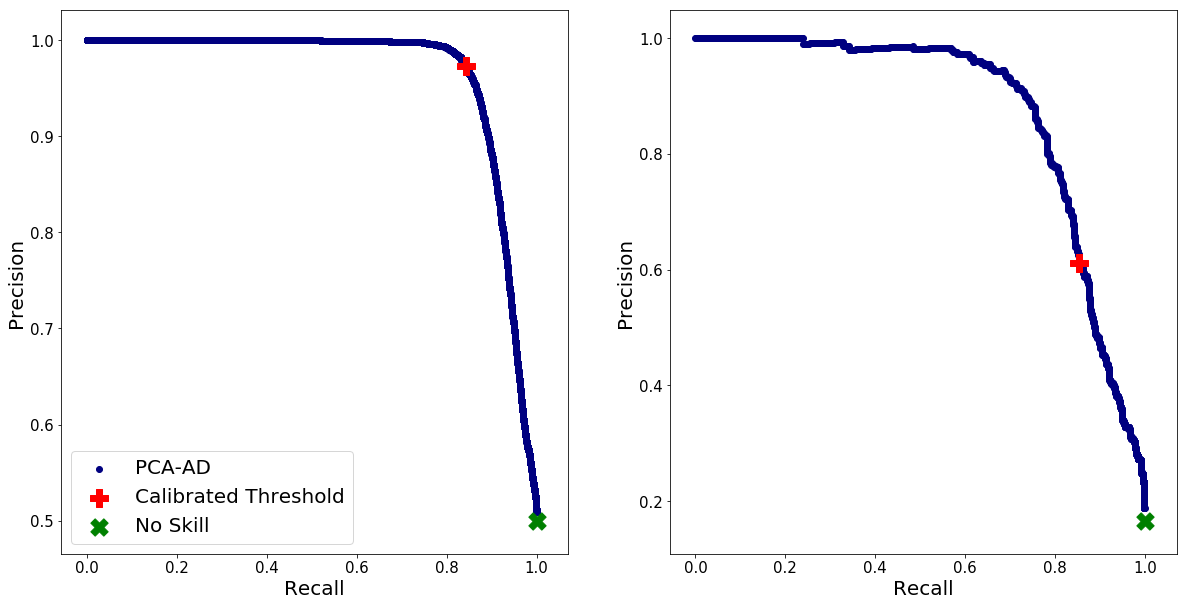

In [10]:
from sklearn.metrics import precision_recall_curve

plt.subplot(1,2,1)
precisionTrain, recallTrain, thresholdsTrain = precision_recall_curve(ytrain, STrain)
idxCaliThreshold = np.argmin(abs(thresholdsTrain -np.array(CalibParamsLoaded['That'])))
plt.scatter(recallTrain,precisionTrain,label='PCA-AD',color='navy')
plt.scatter(recallTrain[idxCaliThreshold],precisionTrain[idxCaliThreshold],label='Calibrated Threshold',marker='P',color='red',s=300)
plt.scatter(recNoSkilltrain,precNoSkilltrain,marker='X',  label='No Skill',color='g',s=300)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Recall',fontsize=20)
plt.ylabel('Precision',fontsize=20)
plt.legend(fontsize=20)

plt.subplot(1,2,2)

precisionTest, recallTest, thresholdsTest = precision_recall_curve(ytest, STest)
idxCaliThreshold = np.argmin(abs(thresholdsTest -np.array(CalibParamsLoaded['That'])))
plt.scatter(recallTest,precisionTest,label='PCA-AD',color='navy')
plt.scatter(recallTest[idxCaliThreshold],precisionTest[idxCaliThreshold],label='Calibrated Threshold',marker='P',color='red',s=300)

plt.scatter(recNoSkilltest,precNoSkilltest, marker='X', label='No Skill',color='g',s=300)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Recall',fontsize=20)
plt.ylabel('Precision',fontsize=20)

plt.show()

In [246]:
print(metrics.auc(recallTest, precisionTest))
print(metrics.auc(recallTrain, precisionTrain))

0.8745078954307058
0.9650132701497952
